In [1]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.graphics as smg
import json
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import math
import numpy as np
import warnings


## Load Data

### Migration influx

In [2]:
with open("../migration_rates/countries.json") as buf:
    countries = list(json.load(buf).keys())

df_all = pd.read_csv(
    "../migration_rates/migration_rate_processed.csv", index_col=0, parse_dates=["date"]
)
df_all.set_index("date", inplace=True)
df_all["value"] = pd.to_numeric(df_all["value"], errors="coerce")

for c in countries:
    df_all.loc[df_all["country"] == c, "value"].fillna(
        df_all.loc[df_all["country"] == c].mean(), inplace=True
    )  # fill missing data with mean

series = {c: df_all[df_all.country == c].value for c in countries}
series["NL"]


date
2010-01-01     763.0
2010-02-01     649.0
2010-03-01     768.0
2010-04-01     772.0
2010-05-01     685.0
               ...  
2019-08-01    1076.0
2019-09-01    1130.0
2019-10-01     994.0
2019-11-01     815.0
2019-12-01     728.0
Name: value, Length: 120, dtype: float64

### Google trends

In [3]:
DATA_VERSION = "21-04-22"

LANGUAGE_ASSIGNMENT_FILE = "../keywords/assignment_language_country.json"


def get_input_file(country: str) -> str:
    directory = f"../processed_data/{DATA_VERSION}"
    if not os.path.exists(directory):
        os.makedirs(directory)
    return os.path.join(directory, f"processed_{country}.csv")


with open(LANGUAGE_ASSIGNMENT_FILE) as f:
    assignment_language_country = json.load(f)

dataframes = {
    c: pd.read_csv(get_input_file(c), header=[0, 1], index_col=0, parse_dates=[0])
    for c in countries
}

keyword_ids = dataframes[countries[0]]["mean"].columns.to_list()
dataframes["NL"].head()


mean                                                         \
keyword_id          2         10         11         12         14         15   
date                                                                           
2007-01-01  12.142857   7.142857  20.714286   0.000000  19.428571  66.142857   
2007-02-01   0.000000   0.000000  56.857143   0.000000   0.000000  54.428571   
2007-03-01   0.000000  72.000000   0.000000  44.571429  13.142857  42.142857   
2007-04-01  16.571429  39.857143  22.285714   0.000000  12.285714  18.142857   
2007-05-01  11.428571   0.000000   5.857143   0.000000  18.285714   0.000000   

                                                        ...       sem  \
keyword_id         16         17         18         19  ...       114   
date                                                    ...             
2007-01-01   0.000000   0.000000  34.142857  28.142857  ...  0.746876   
2007-02-01  23.857143  36.000000   0.000000  32.000000  ...  0.918443   
2007-03-01   0.000000  36.428571   0.000000  37.285714  ...  1.445142   
2007-04-01   0.000000   0.000000   0.000000  35.285714  ...  1.148794   
2007-05-01   0.000000   0.000000  20.857143  37.857143  ...  1.078548   

                                                                        \
keyword_id       115       117       118       119       121       122   
date                                                                     
2007-01-01  4.838901  4.921838  1.269742  1.130890  1.242666  2.918391   
2007-02-01  2.542161  1.784285  2.307928  0.961858  1.360272  3.508008   
2007-03-01  5.588496  4.276180  1.737932  1.151751  0.911006  3.952094   
2007-04-01  4.495652  4.729413  1.442786  0.755929  1.127878  4.779491   
2007-05-01  6.014721  5.019011  1.397276  1.016865  0.404061  7.008256   

                                          
keyword_id       123       124       125  
date                                      
2007-01-01  1.056242  0.925820  0.480929  
2007-02-01  1.317078  1.192379  0.611678  
2007-03-01  0.972408  0.577350  0.606092  
2007-04-01  0.459221  0.737711  0.714286  
2007-05-01  0.993174  0.968904  0.649437  

[5 rows x 96 columns]

### Macroeconomics

In [4]:
def read_gdp(filename, country_names, skiprows=10, nrows=38):
    df = pd.read_excel(filename, skiprows=skiprows, nrows=nrows)

    country_names_inv = {v: k for k, v in country_names.items()}

    df = (
        df[df["GEO/TIME"].isin(country_names.values())]
        .replace(country_names_inv)
        .set_index("GEO/TIME")
        .transpose()
        .stack()
        .reset_index(level=[1])
        .rename(columns={0: "gdp", "GEO/TIME": "country"})
    )
    df.index = pd.to_datetime(df.index)
    return df


def read_unempl(filename, country_names, skiprows=10, nrows=29):
    df = pd.read_excel(filename, skiprows=skiprows, nrows=nrows, sheet_name="Sheet 1")

    country_names_inv = {v: k for k, v in country_names.items()}

    df = (
        df.drop(columns=df.filter(like="Unnamed"), index=0)
        .loc[df["TIME"].isin(country_names.values())]
        .replace(country_names_inv)
        .set_index("TIME")
        .transpose()
        .stack()
        .reset_index(level=[1])
        .rename(columns={0: "unempl", "TIME": "country"})
        .replace({":": np.nan})
    )

    df.index = pd.to_datetime(df.index)
    return df


def read_share_young_pop(filename, country_names, skiprows=9, nrows=29):
    df = pd.read_excel(filename, skiprows=skiprows, nrows=nrows, sheet_name="Share Young Pop")

    country_names_inv = {v: k for k, v in country_names.items()}

    df = (
        df.drop(columns=df.filter(like="Unnamed"), index=0)
        .loc[df["TIME"].isin(country_names.values())]
        .replace(country_names_inv)
        .set_index("TIME")
        .transpose()
        .stack()
        .reset_index(level=[1])
        .rename(columns={0: "share_young_pop", "TIME": "country"})
    )

    df.index = pd.to_datetime(df.index)
    return df


with open("../macroeconomics/country_names.json") as f:
    country_names = json.load(f)

df_gdp = read_gdp("../macroeconomics/GDP_pc_quart.xls", country_names)
df_unempl = read_unempl("../macroeconomics/Unemployment_Rate_Quart.xlsx", country_names)
df_share_young_pop = read_share_young_pop("../macroeconomics/Share_Young_Population.xlsx", country_names)
df_share_young_pop
# df_unempl


,country,share_young_pop
2004-01-01,BE,0.183531
2004-01-01,BG,0.209908
2004-01-01,CZ,0.225508
2004-01-01,DK,0.176100
2004-01-01,EE,0.217808
...,...,...
2019-01-01,LU,0.191188
2019-01-01,HU,0.171723
2019-01-01,NL,0.188275
2019-01-01,AT,0.177618


### Resample, transform and merge

In [152]:
dfs_1m = {
    k: ((df - df.shift(12)).rolling(3).mean()/df.mean()).fillna(0) for k, df in dataframes.items()
}
sers_1m = {
    k: ((df - df.shift(12)) / df.shift(12)).fillna(0) for k, df in series.items()
}

tmp_dfs = []

for c in countries:
    tmp_dep = (
        sers_1m[c]
        .to_frame()
        .assign(country=c)
        .assign(month=sers_1m[c].index.month.astype(str))
    )
    tmp_ind = dfs_1m[c]["mean"].shift(1)
    tmp_ind_1 = dfs_1m[c]["mean"].shift(2).rename(columns=lambda x: x + "_1")
    tmp_ind_2 = dfs_1m[c]["mean"].shift(2).rename(columns=lambda x: x + "_2")
    tmp_ind_3 = dfs_1m[c]["mean"].shift(4).rename(columns=lambda x: x + "_3")
    tmp_ind_6 = dfs_1m[c]["mean"].shift(7).rename(columns=lambda x: x + "_6")
    tmp_ind_9 = dfs_1m[c]["mean"].shift(10).rename(columns=lambda x: x + "_9")
    tmp_ind_12 = dfs_1m[c]["mean"].shift(13).rename(columns=lambda x: x + "_12")
    tmp_df = pd.concat(
        [tmp_dep, tmp_ind, tmp_ind_1, tmp_ind_2, tmp_ind_3, tmp_ind_6, tmp_ind_9, tmp_ind_12], axis=1
    )["2010-12-31":"2019-12-31"]
    tmp_dfs.append(tmp_df)

df_panel_1y = pd.concat(tmp_dfs).sort_index()

for df in [df_share_young_pop, df_gdp, df_unempl]:
    df_tmp = (
        df.groupby([pd.Grouper(freq="1M"), "country"]).mean().shift(12).pct_change()
    )
    df_panel_1y = df_panel_1y.join(
        df_tmp, on=[df_panel_1y.index, df_panel_1y["country"]], how="left"
    )

df_panel_1y


,value,country,month,2,10,11,12,14,15,16,...,118_12,119_12,121_12,122_12,123_12,124_12,125_12,share_young_pop,gdp,unempl
date,,,,,,,,,,,,,,,,,,,,,
2011-01-01,0.029834,FR,1,-0.593569,1.251277,-0.260629,0.031828,-0.091733,-0.326579,-0.369384,...,0.011159,0.515199,-0.018335,-0.073258,-0.114566,0.010051,0.071812,NaN,NaN,NaN
2011-01-01,0.321429,IE,1,0.000000,0.000000,1.052316,0.000000,0.000000,0.000000,0.000000,...,0.578553,-0.008067,0.015567,-0.422182,-0.178528,0.031708,-0.005088,NaN,NaN,NaN
2011-01-01,0.732977,GR,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.399310,0.058481,0.074495,-0.329627,-0.016501,-0.008687,0.141628,NaN,NaN,NaN
2011-01-01,0.226792,HU,1,0.000000,0.000000,1.273363,0.000000,0.000000,0.000000,0.000000,...,0.437476,0.006373,-0.101207,-0.030687,0.239259,0.068326,0.207224,NaN,NaN,NaN
2011-01-01,0.483844,BG,1,0.000000,0.000000,-0.610010,1.645272,2.131980,0.000000,0.000000,...,0.245127,0.224894,0.096645,0.042385,0.037686,-0.108856,0.314806,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-01,0.257732,IE,12,0.000000,0.000000,0.362495,0.000000,0.000000,0.000000,0.000000,...,-0.136704,0.010083,0.027675,0.147076,-0.025504,0.200159,0.081412,NaN,NaN,NaN
2019-12-01,-0.008174,NL,12,0.060696,0.387968,0.340865,-0.473446,0.481731,-0.688525,0.358189,...,-0.085236,0.012364,0.068691,0.024275,-0.062957,0.097213,0.163837,NaN,NaN,NaN
2019-12-01,0.000000,SK,12,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.123043,0.038628,-0.026673,0.318732,0.025036,0.088129,0.464164,NaN,NaN,NaN


## Evaluation functions and common variables

In [153]:
from sklearn import linear_model
from sklearn import model_selection
from sklearn import ensemble
from sklearn import metrics
from sklearn import pipeline
from sklearn import preprocessing
from sklearn import svm
from sklearn import decomposition
from sklearn import discriminant_analysis
from sklearn import feature_selection
from sklearn import compose
from sklearn import impute

t_min = "2011-01-01"
t_max = "2019-12-01"
t_split_lower = "2017-12-01"
t_split_upper = "2018-01-01"

scoring = ["neg_mean_absolute_percentage_error", "neg_root_mean_squared_error", "r2"]

# selected_countries = ["FR", "GB", "IT", "ES", "RO"]
selected_countries = countries


df_panel_1y = df_panel_1y[df_panel_1y.country.isin(selected_countries)]

dummies_country = pd.get_dummies(df_panel_1y["country"], drop_first=False)
dummy_cols = dummies_country.columns.tolist()

dummies_month = pd.get_dummies(df_panel_1y["month"], prefix="month", drop_first=False)
dummy_cols_month = dummies_month.columns.tolist()

df_tmp_combined = df_panel_1y["country"] + "_" + df_panel_1y["month"]
dummies_combined = pd.get_dummies(df_tmp_combined, drop_first=False)
dummy_cols_combined = dummies_combined.columns.tolist()

df_panel_1y = pd.concat(
    [df_panel_1y, dummies_country, dummies_month, dummies_combined], axis=1
)

x = df_panel_1y.drop(columns="value")[t_min:t_max]
y = df_panel_1y["value"][t_min:t_max]

x_train = x[t_min:t_split_lower]
y_train = y[t_min:t_split_lower]
x_test = x[t_split_upper:t_max]
y_test = y[t_split_upper:t_max]


def score_cv(reg, X, y):
    scores = model_selection.cross_validate(reg, X=X, y=y, scoring=scoring)
    return pd.DataFrame(scores)


def score_test(reg, X, y):
    scores = {s: metrics.get_scorer(s)(reg, X, y) for s in scoring}
    return pd.Series(scores)


def plot_panel(df, countries, n_rows=7, n_cols=4, figsize=(25, 25), autoscale=True):
    fig, axs = plt.subplots(n_rows, n_cols, figsize=figsize)
    for c, ax in zip(countries, axs.flatten()):
        df_to_plot = df[df["country"] == c].drop(columns="country")
        if autoscale is not None:
            y_max = max([df_to_plot[col].max() for col in df_to_plot.columns])
            y_min = min([df_to_plot[col].min() for col in df_to_plot.columns])
        df_to_plot.plot(ax=ax, ylim=(y_min * 1.2, y_max * 1.2) if autoscale else None)
        ax.set_title(c)
    fig.tight_layout()
    return fig, axs


def plot_prediction(reg, X, countries=selected_countries, **kwargs):
    y_pred = reg.predict(X)
    df_pred = df_panel_1y[["value", "country"]][t_min:t_max].assign(pred=y_pred)
    return plot_panel(df_pred, countries, **kwargs)


def plot_residuals(reg, X, countries=selected_countries, **kwargs):
    y_pred = reg.predict(X)
    df_pred = df_panel_1y[["value", "country"]][t_min:t_max].assign(pred=y_pred)
    df_pred["residuals"] = df_pred["pred"] - df_pred["value"]
    return plot_panel(df_pred[["residuals", "country"]], countries, **kwargs)



## Models

### Country dummies

,fit_time,score_time,test_neg_mean_absolute_percentage_error,test_neg_root_mean_squared_error,test_r2
0,0.006060,0.007785,-2.174805e+12,-0.442910,-0.680716
1,0.004671,0.004297,-6.163562e+11,-0.254079,0.107130
2,0.006916,0.003441,-1.801843e+12,-0.348743,0.028365
3,0.003985,0.003099,-4.162610e+12,-0.223577,-0.727538
4,0.005492,0.002725,-1.116502e+12,-0.244092,-2.664338


Mean CV score:


fit_time                                   5.424643e-03
score_time                                 4.269505e-03
test_neg_mean_absolute_percentage_error   -1.974423e+12
test_neg_root_mean_squared_error          -3.026804e-01
test_r2                                   -7.874194e-01
dtype: float64

OOS score:


neg_mean_absolute_percentage_error   -3.737661e+13
neg_root_mean_squared_error          -2.009253e-01
r2                                   -1.414099e+00
dtype: float64

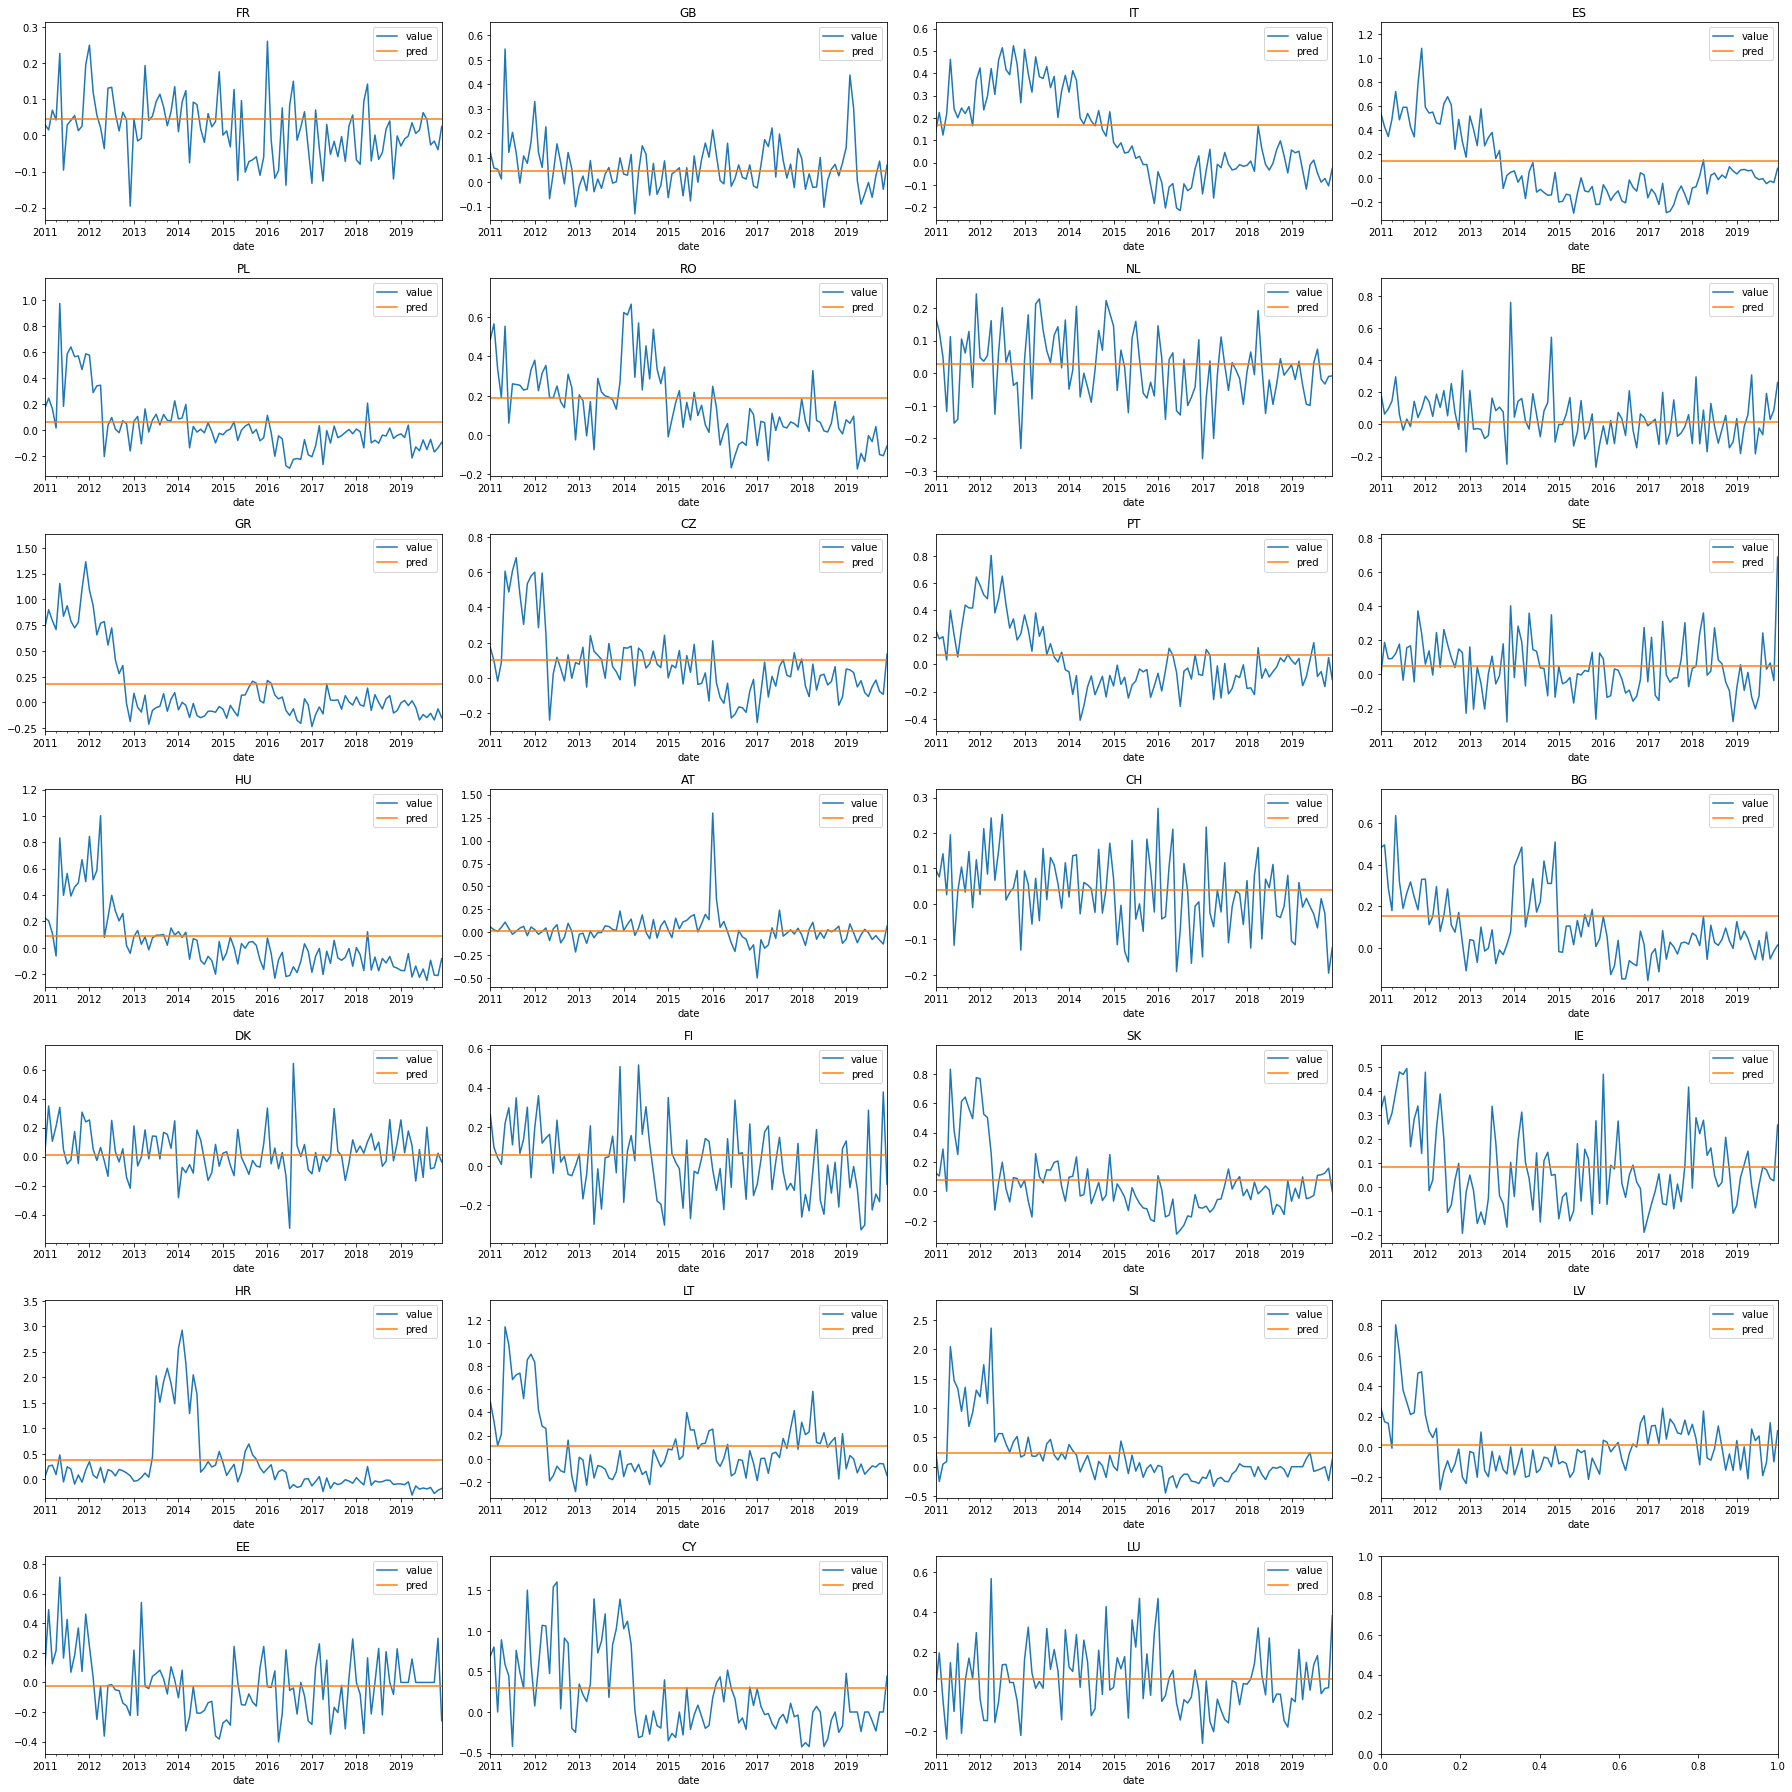

In [154]:
features = dummy_cols

reg = linear_model.LinearRegression()

reg.fit(x_train[features], y_train)

cv_score = score_cv(reg, x_train[features], y_train)
display(cv_score)
print("Mean CV score:")
display(cv_score.mean())
print("OOS score:")
test_score = score_test(reg, x_test[features], y_test)
display(test_score)
fig, axs = plot_prediction(reg, x[features])



,fit_time,score_time,test_neg_mean_absolute_percentage_error,test_neg_root_mean_squared_error,test_r2
0,0.009969,0.004137,-5.487516e+11,-0.404819,-0.404056
1,0.006770,0.004335,-1.025703e+12,-0.273522,-0.034751
2,0.004503,0.002230,-2.085006e+12,-0.348602,0.029151
3,0.009954,0.003492,-2.322435e+12,-0.165032,0.058747
4,0.002903,0.007626,-9.424600e+11,-0.133758,-0.100338


Mean CV score:


fit_time                                   6.819582e-03
score_time                                 4.363966e-03
test_neg_mean_absolute_percentage_error   -1.384871e+12
test_neg_root_mean_squared_error          -2.651465e-01
test_r2                                   -9.024935e-02
dtype: float64

OOS score:


neg_mean_absolute_percentage_error   -1.061275e+13
neg_root_mean_squared_error          -1.399903e-01
r2                                   -1.718757e-01
dtype: float64

19       0.157116
19_3     0.056226
19_6     0.037998
19_9     0.041638
19_12    0.112911
dtype: float64

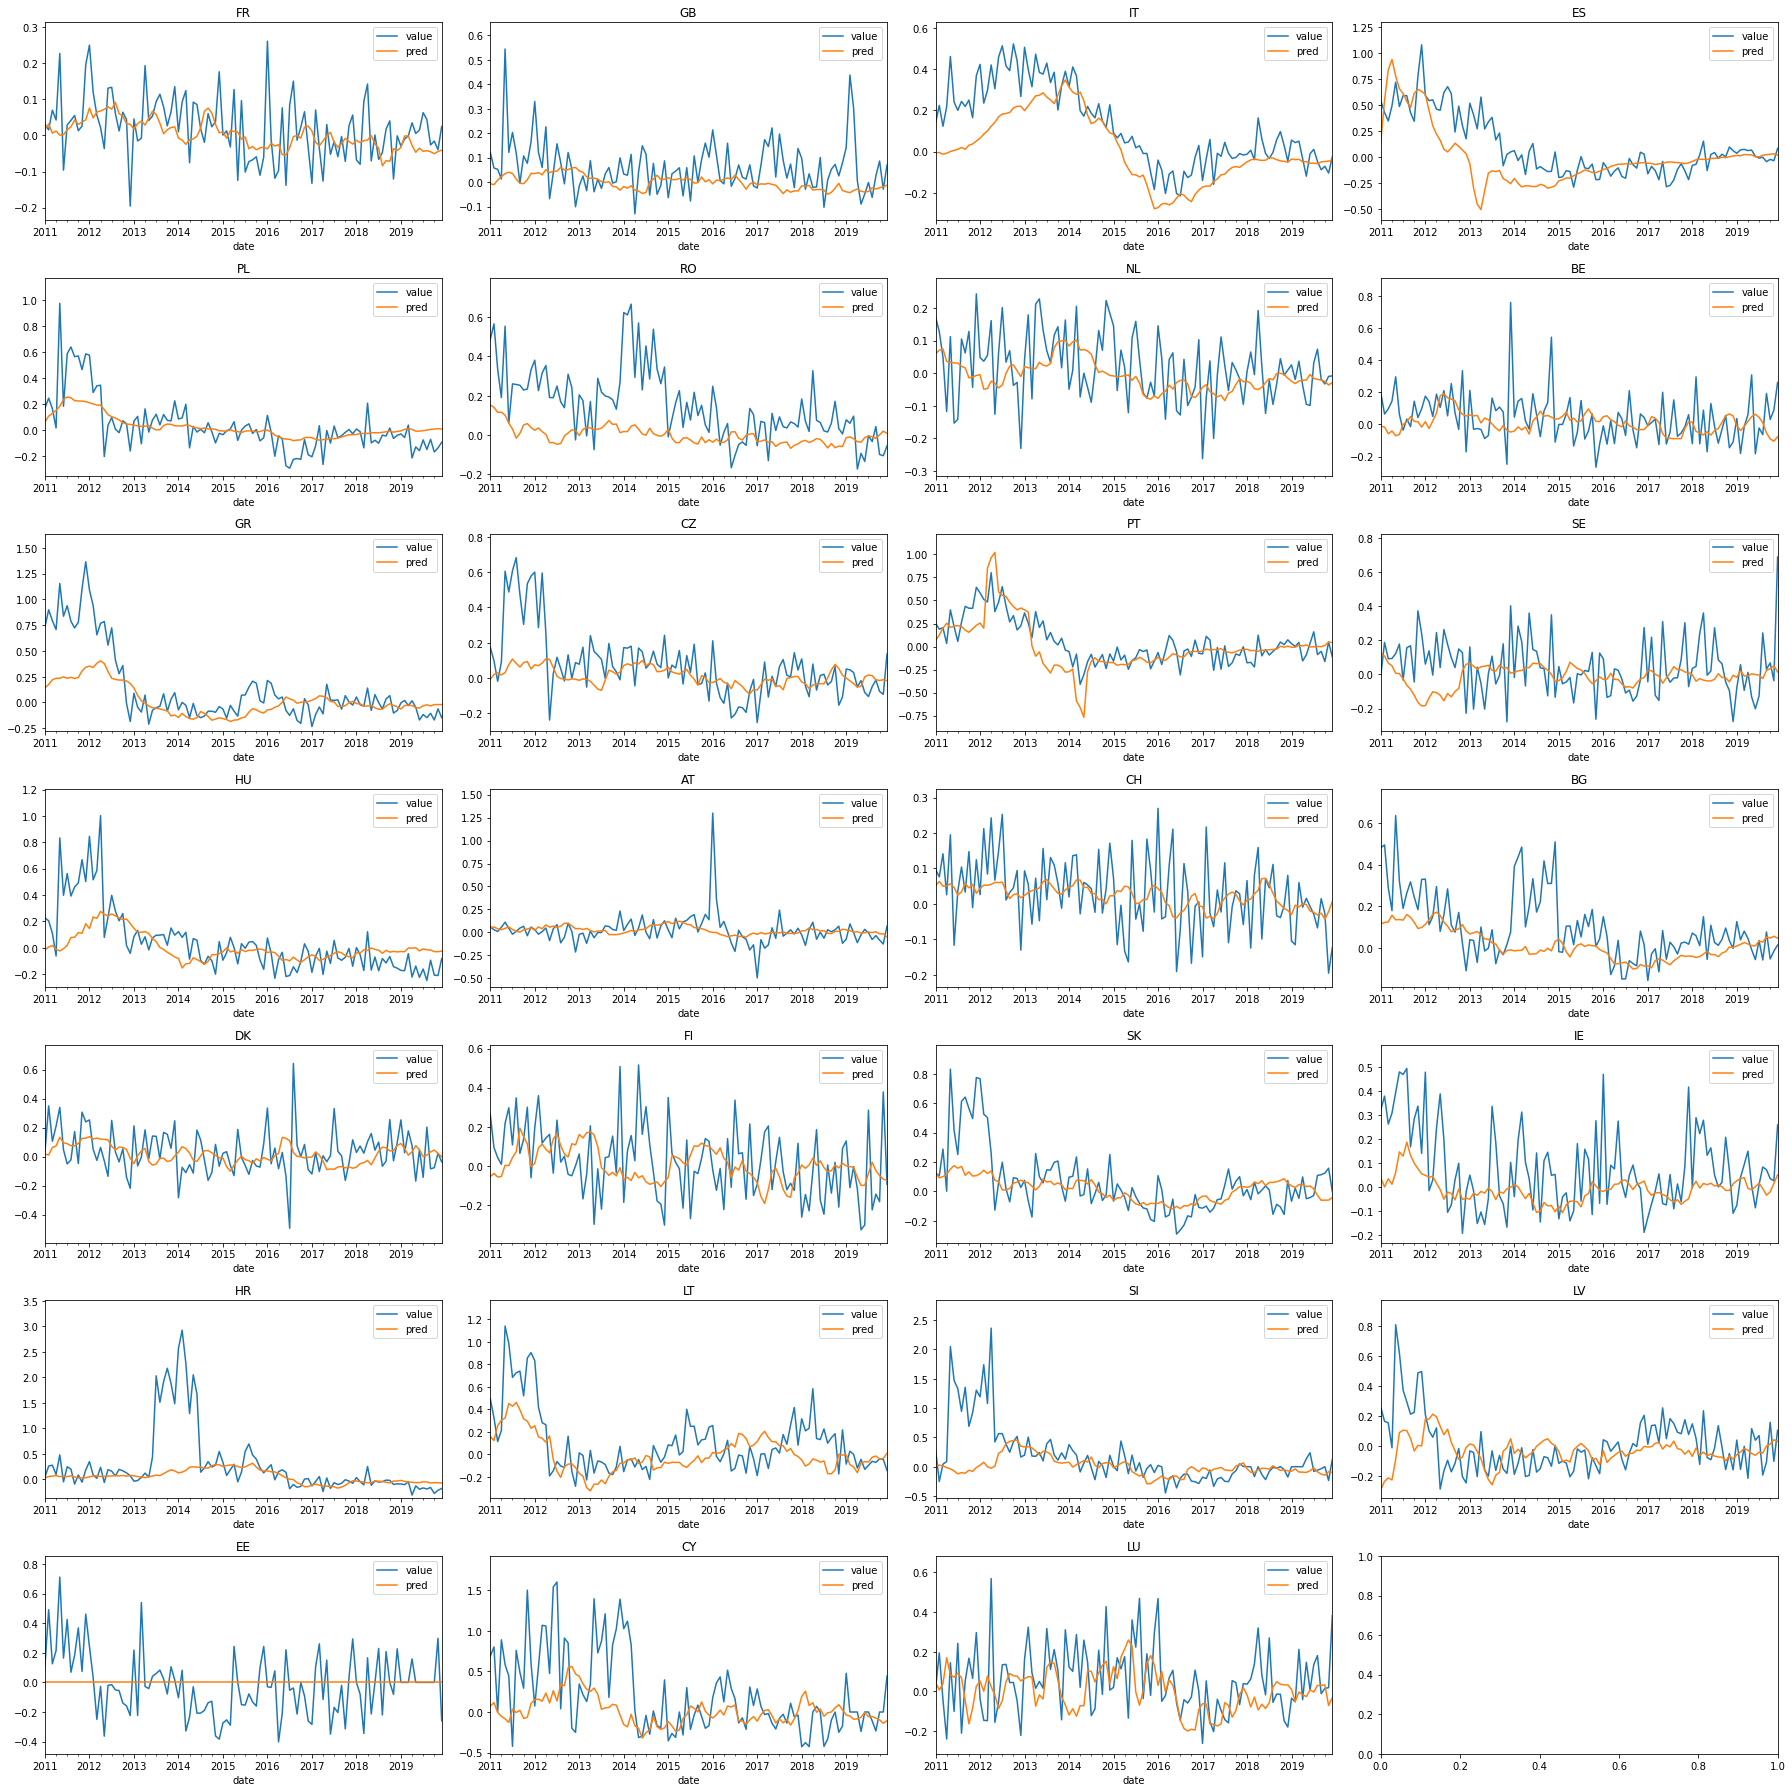

In [155]:
features = ["19", "19_3", "19_6", "19_9", "19_12"]

reg = linear_model.LinearRegression(fit_intercept=False)

# reg = ensemble.GradientBoostingRegressor()

reg.fit(x_train[features], y_train)

cv_score = score_cv(reg, x_train[features], y_train)
display(cv_score)
print("Mean CV score:")
display(cv_score.mean())
print("OOS score:")
test_score = score_test(reg, x_test[features], y_test)
display(test_score)

display(pd.Series(reg.coef_, index=features))

fig, axs = plot_prediction(reg, x[features])



### plus GTI

/home/stei509/anaconda3/envs/eumf/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/home/stei509/anaconda3/envs/eumf/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/home/stei509/anaconda3/envs/eumf/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33.8122376120824, tolerance: 0.011678882240701603
  model = cd_fast.enet_coordinate_descent(
/home/stei509/anaconda3/envs/eumf/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: UserWarning: With alpha=0, this algorithm 

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.749285,0.200314,0.006700,0.001252,0.0,-0.412546,-0.292752,-0.328580,-0.252268,-0.266264,-0.310482,0.057277,15
1,0.050944,0.004260,0.005273,0.001511,0.000001,-0.412501,-0.292679,-0.328543,-0.252207,-0.266171,-0.310420,0.057290,14
2,0.061164,0.023395,0.008316,0.002445,0.00001,-0.412114,-0.292033,-0.328212,-0.251669,-0.265352,-0.309876,0.057407,13
3,0.031628,0.003198,0.007005,0.000674,0.0001,-0.408602,-0.286327,-0.325204,-0.246518,-0.257351,-0.304800,0.058618,12
4,0.020402,0.003017,0.005418,0.000788,0.001,-0.389558,-0.258430,-0.322610,-0.218713,-0.226266,-0.283115,0.064620,4
5,0.013426,0.001639,0.005543,0.001029,0.01,-0.390295,-0.257940,-0.335184,-0.181896,-0.171773,-0.267418,0.085138,1
6,0.013627,0.001721,0.005233,0.000861,0.002,-0.385419,-0.254743,-0.330098,-0.204437,-0.206305,-0.276200,0.071175,3
7,0.015064,0.001622,0.005961,0.000863,0.005,-0.384930,-0.260115,-0.330943,-0.187178,-0.176379,-0.267909,0.080775,2
8,0.014099,0.001091,0.006585,0.000399,0.1,-0.427647,-0.270010,-0.353849,-0.207291,-0.202797,-0.292319,0.086996,5
9,0.013257,0.001226,0.005630,0.000945,0.2,-0.427647,-0.270010,-0.353849,-0.207291,-0.202797,-0.292319,0.086996,5


LASSO Coefficients:
19        0.112360
19_12     0.065592
19_3      0.045252
19_9      0.026643
19_6      0.025459
39_9      0.000000
38_9     -0.000000
37_9      0.000000
33_9      0.000000
32_9      0.000000
28_9      0.000000
26_9      0.000000
24_9      0.000000
22_9      0.000000
21_9      0.000000
20_9      0.000000
41_9     -0.000000
2        -0.000000
18_9     -0.000000
43_9      0.000000
44_9      0.000000
48_9      0.000000
49_9      0.000000
51_9      0.000000
52_9     -0.000000
54_9      0.000000
55_9     -0.000000
56_9     -0.000000
57_9     -0.000000
58_9      0.000000
59_9     -0.000000
42_9      0.000000
17_9     -0.000000
112_9    -0.000000
117_6     0.000000
52_6     -0.000000
54_6      0.000000
55_6     -0.000000
56_6     -0.000000
57_6     -0.000000
58_6      0.000000
59_6     -0.000000
60_6     -0.000000
112_6    -0.000000
113_6    -0.000000
114_6    -0.000000
115_6     0.000000
118_6    -0.000000
16_9      0.000000
119_6    -0.000000
121_6    -0.000000
122_6    -0

,fit_time,score_time,test_neg_mean_absolute_percentage_error,test_neg_root_mean_squared_error,test_r2
0,0.038924,0.035184,-1.023850e+12,-0.390295,-0.305117
1,0.084376,0.016678,-1.679915e+12,-0.257940,0.079786
2,0.021106,0.007108,-4.878473e+12,-0.335184,0.102451
3,0.020846,0.008604,-2.208191e+12,-0.181896,-0.143458
4,0.036460,0.009393,-2.772908e+12,-0.171773,-0.814667


Mean CV score:


fit_time                                   4.034219e-02
score_time                                 1.539350e-02
test_neg_mean_absolute_percentage_error   -2.512667e+12
test_neg_root_mean_squared_error          -2.674177e-01
test_r2                                   -2.162010e-01
dtype: float64

OOS score:


neg_mean_absolute_percentage_error   -1.658895e+13
neg_root_mean_squared_error          -1.625751e-01
r2                                   -5.804971e-01
dtype: float64

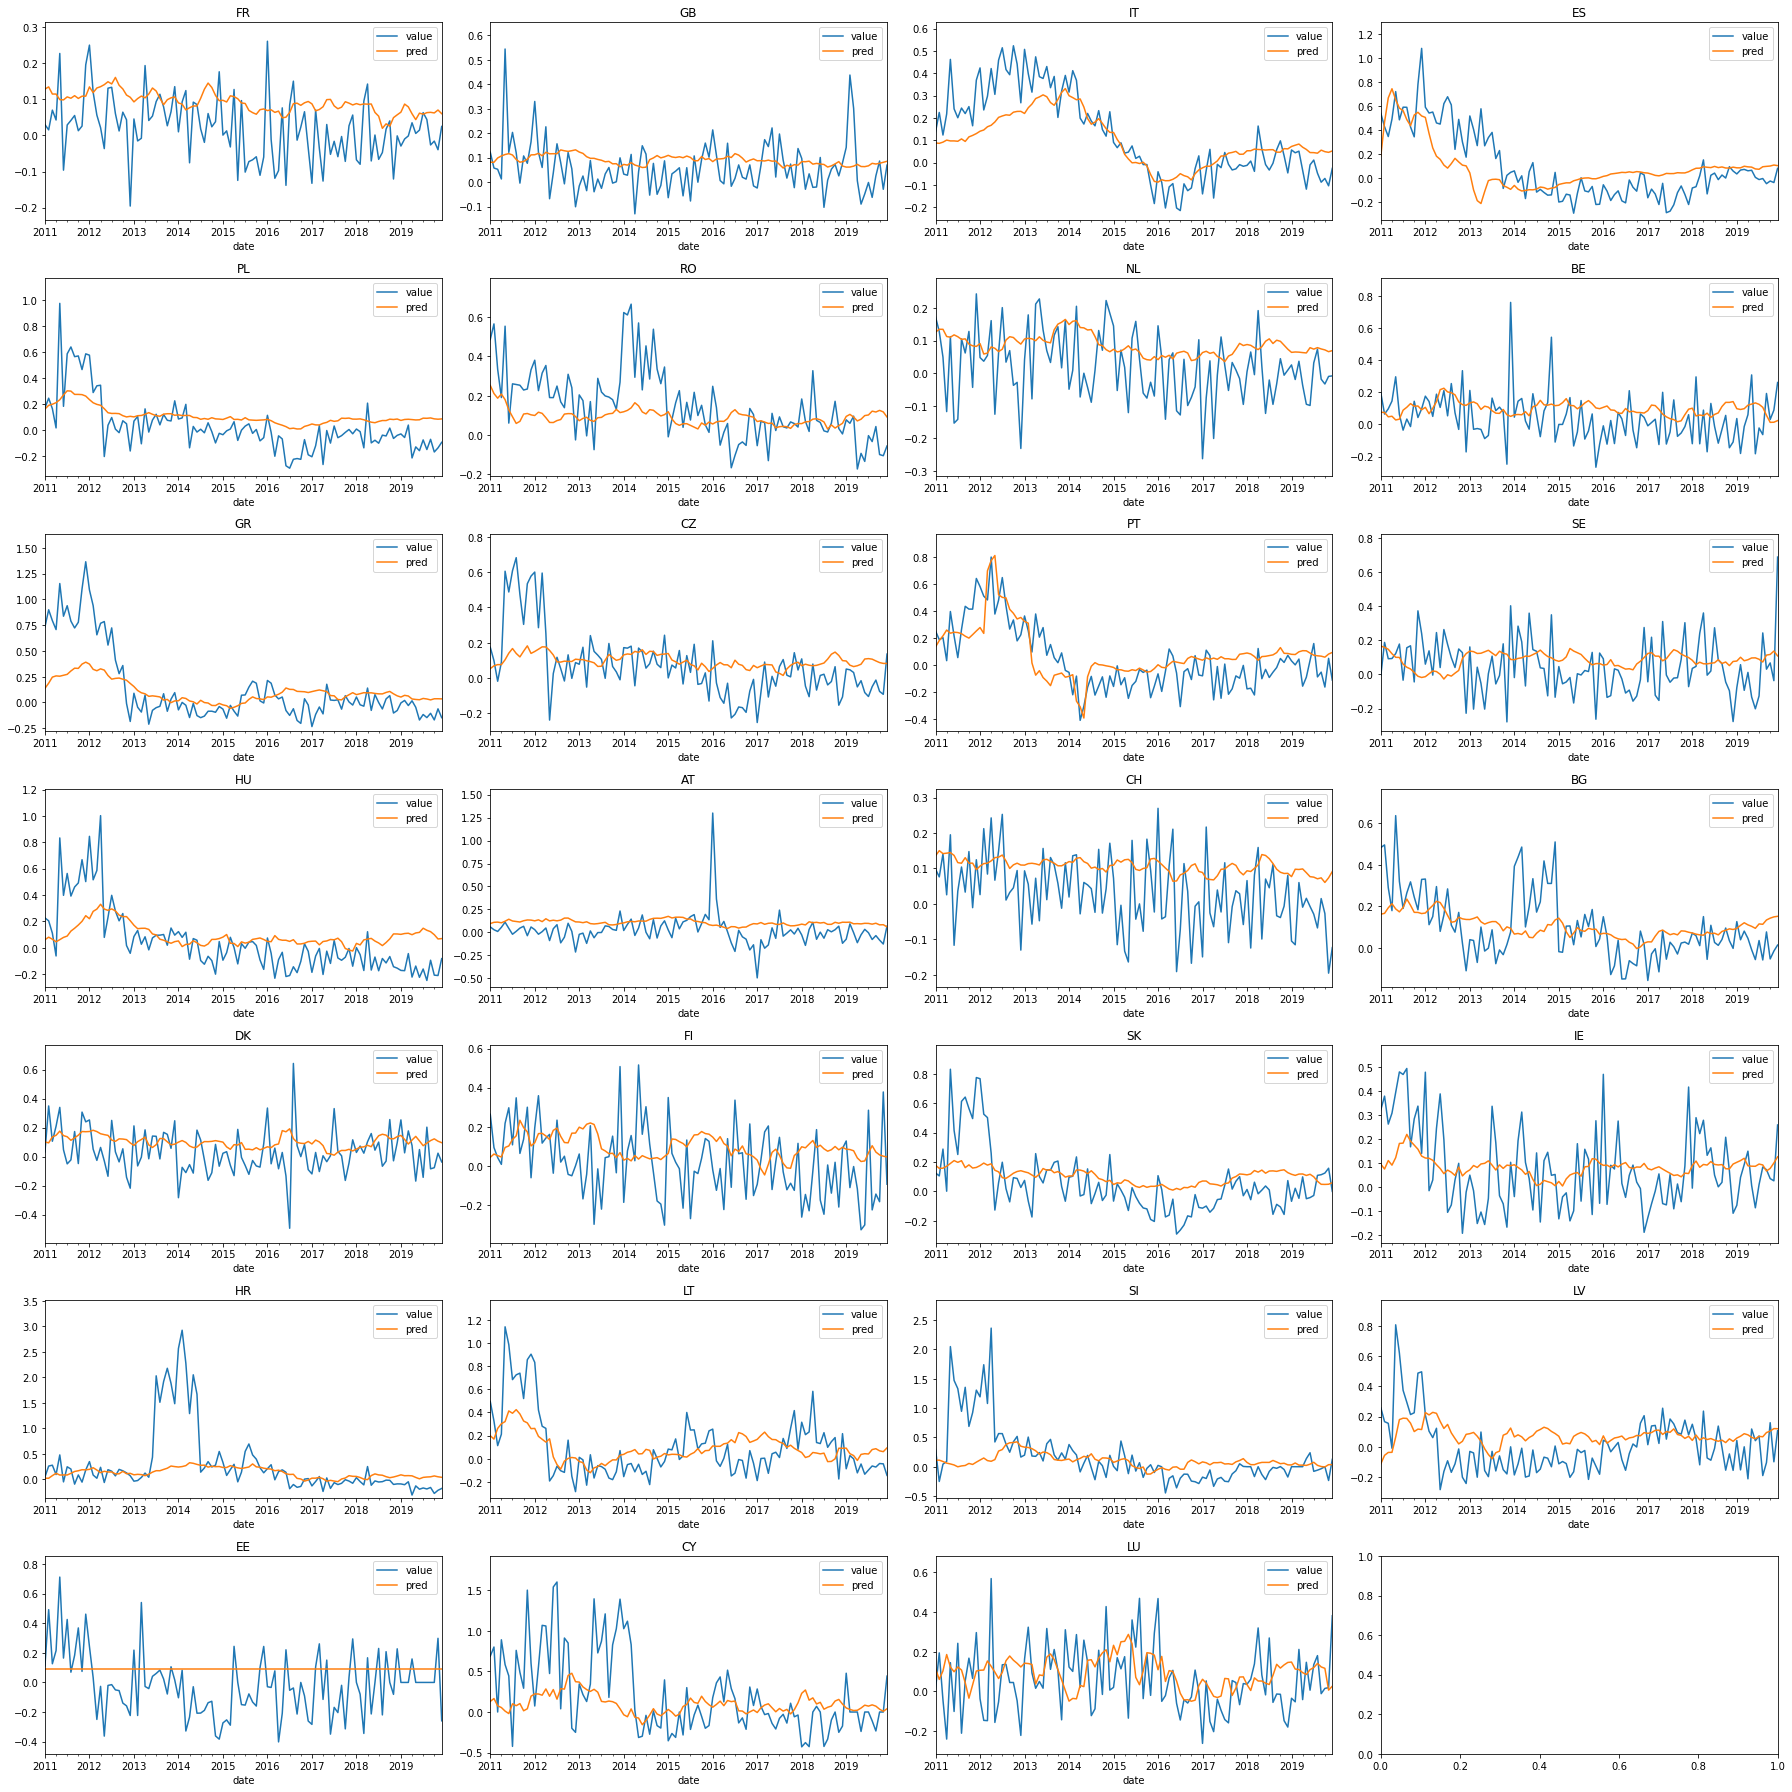

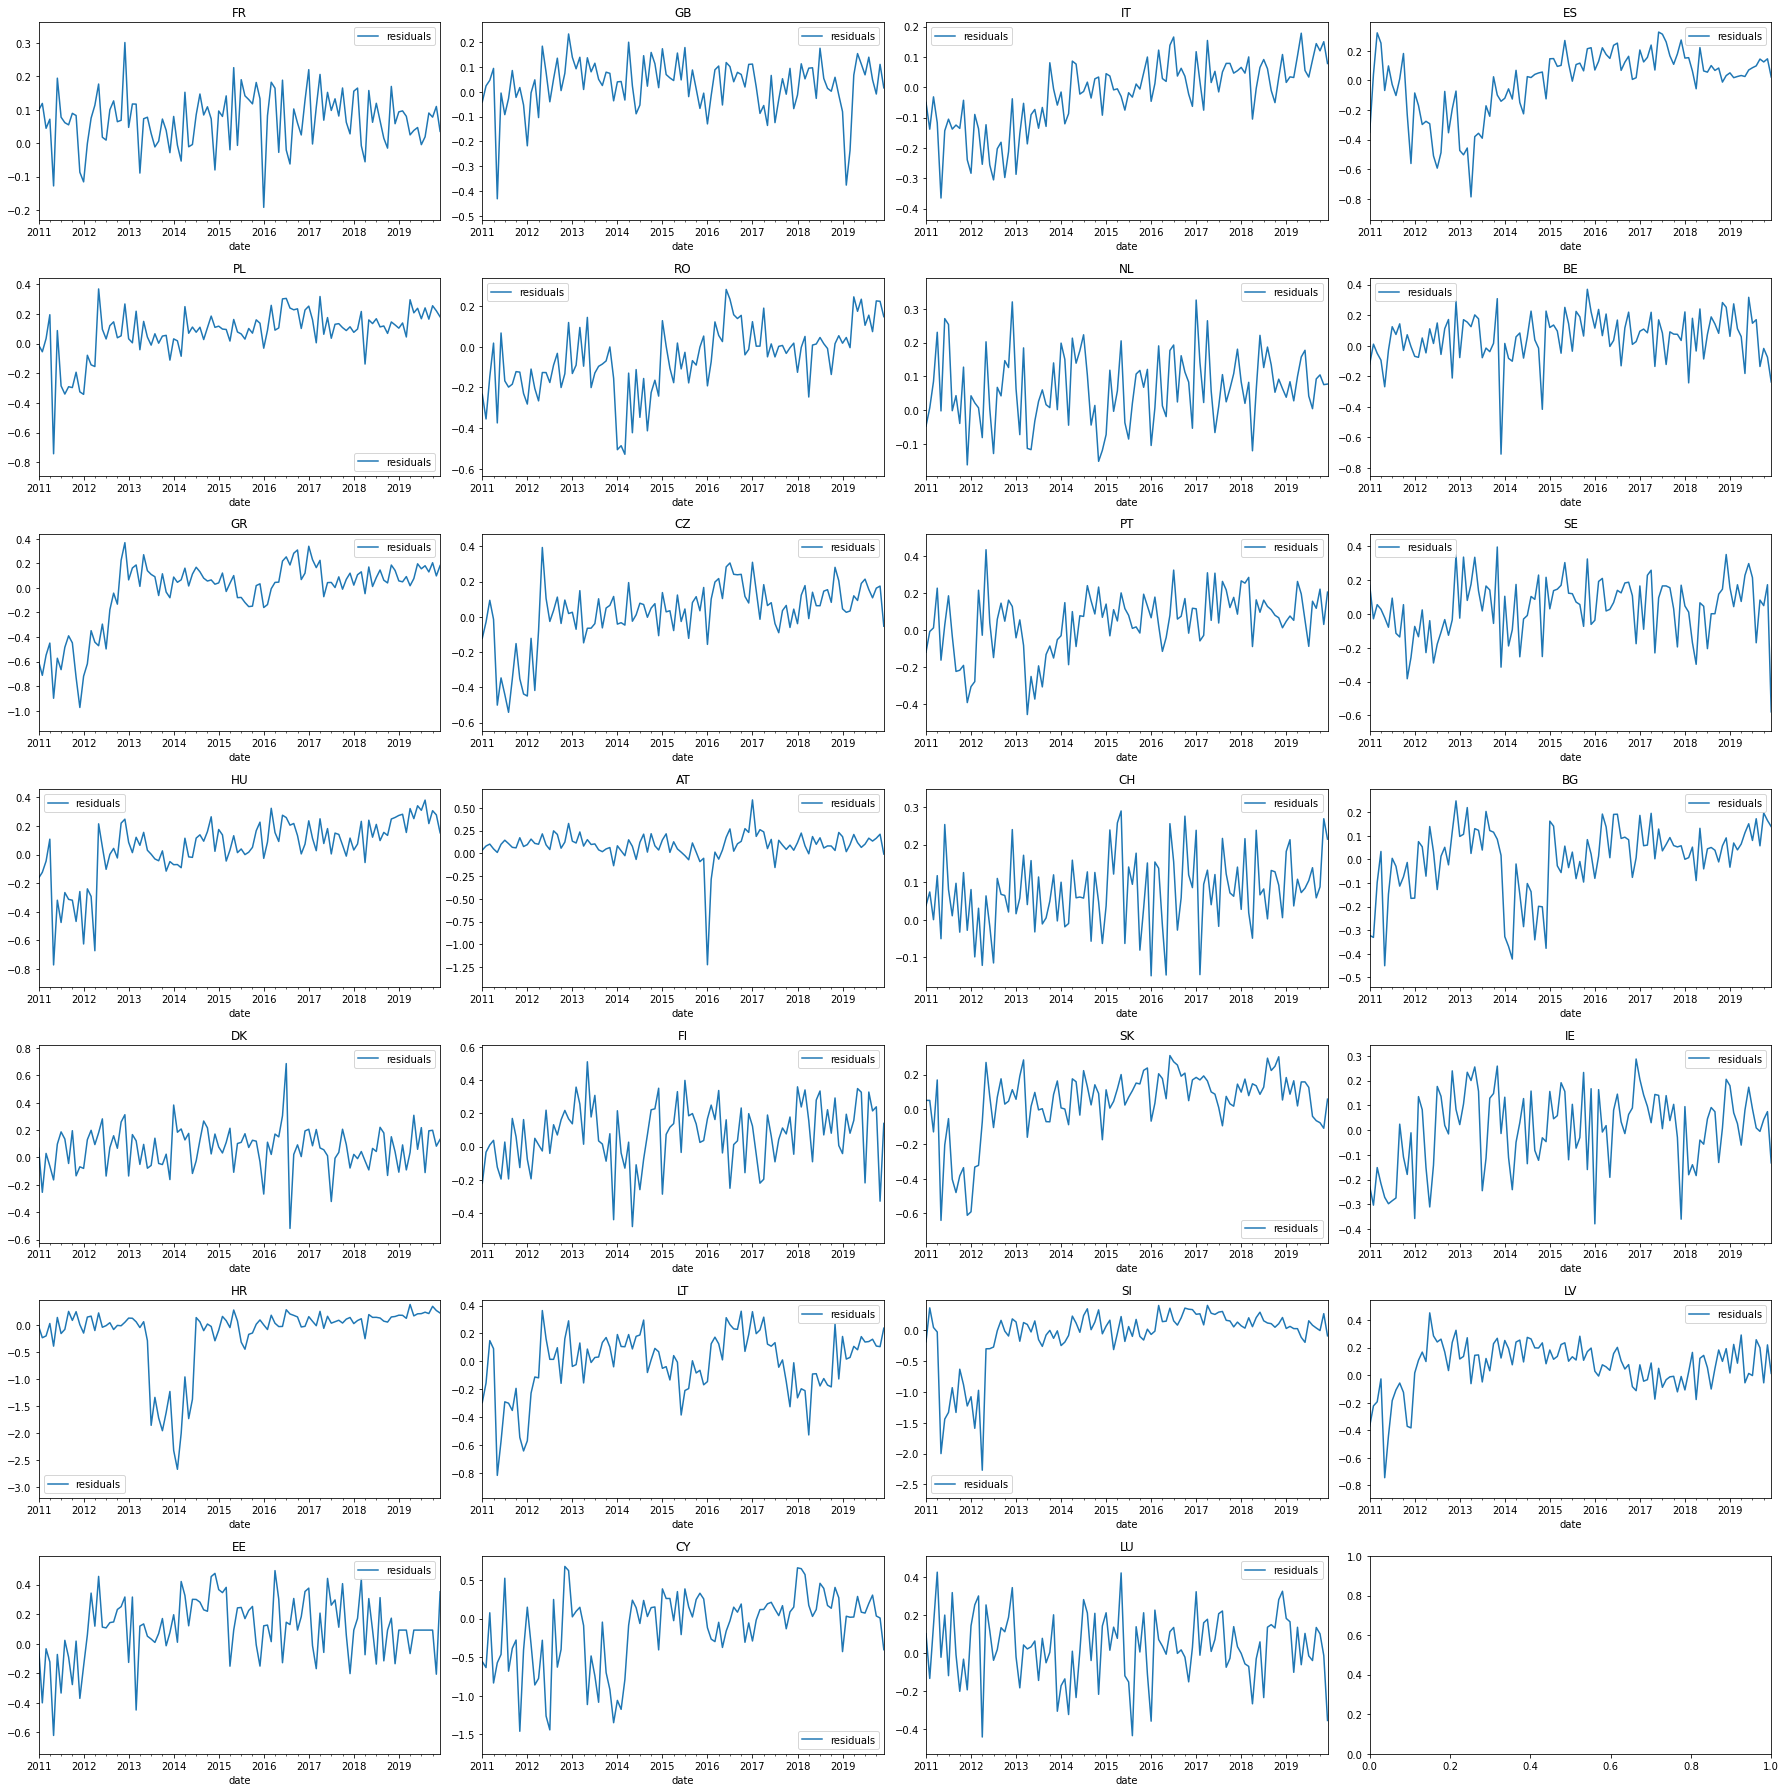

In [162]:
features = (
    keyword_ids
    + [k + "_3" for k in keyword_ids]
    + [k + "_6" for k in keyword_ids]
    + [k + "_9" for k in keyword_ids]
    + [k + "_12" for k in keyword_ids]
)

# reg = linear_model.Lasso(positive=True, normalize=True, alpha=10.0)
reg_unfitted = linear_model.Lasso(normalize=False, positive=True)
# reg_unfitted = linear_model.LinearRegression()
params = {
    "alpha": [
        0.0,
        0.000001,
        0.00001,
        0.0001,
        0.001,
        0.01,
        0.002,
        0.005,
        0.1,
        0.2,
        0.5,
        1.0,
        2.0,
        5.0,
        10.0,
    ],
}
tuner = model_selection.GridSearchCV(
    reg_unfitted, params, scoring="neg_root_mean_squared_error"
)

tuner.fit(x_train[features], y_train)

display(pd.DataFrame(tuner.cv_results_).drop(columns="params"))
reg = tuner.best_estimator_

lasso_coefs = reg.coef_
print("LASSO Coefficients:")
print(pd.Series(lasso_coefs, features).sort_values(ascending=False).to_string())


cv_score = score_cv(reg, x_train[features], y_train)
display(cv_score)
print("Mean CV score:")
display(cv_score.mean())
print("OOS score:")
test_score = score_test(reg, x_test[features], y_test)
display(test_score)
fig, axs = plot_prediction(reg, x[features])
fig, axs = plot_residuals(reg, x[features])

